## Baysian optimzation for Valve

In [90]:
from ax import Client, RangeParameterConfig, ChoiceParameterConfig

from ax.analysis.analysis import (
    Analysis,   
    AnalysisCard,
    AnalysisCardCategory,
    AnalysisCardLevel,
)

from ax.generation_strategy.model_spec import GeneratorSpec
from ax.modelbridge.registry import Generators

from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP, MultiTaskGP
from botorch.models.transforms.input import Warp
from botorch.models.map_saas import AdditiveMapSaasSingleTaskGP
from botorch.models.multitask import KroneckerMultiTaskGP
from ax.utils.stats.model_fit_stats import MSE
from ax.models.torch.botorch_modular.surrogate import SurrogateSpec, ModelConfig

from ax.analysis.plotly.parallel_coordinates import ParallelCoordinatesPlot
from ax.analysis.plotly.surface.slice import SlicePlot

from botorch.acquisition.logei import qLogNoisyExpectedImprovement, qLogExpectedImprovement

import pandas as pd
import numpy as np
from scipy.stats import qmc
import random
import pickle

from utils import score_vals, param_to_list, list_to_param, combine_meta_test, df_to_sv, df_to_sv_valve, \
                add_trials_valve, df_for_new_trials_valve, validate_parameters, construct_generation_strategy_valve, \
                extract_crack_pressure, extract_delta_p

# Mute warnings:
import warnings
warnings.filterwarnings('ignore')



## Generation Strategy - set up to go directly to BayZop
#### https://ax.dev/docs/tutorials/modular_botorch/

In [91]:
# GENERATION_SET = False

In [92]:
surrogate_spec = SurrogateSpec(
    model_configs=[
        # Select between two models:
        # An additive mixture of relatively strong SAAS priors with input Warping.
        # A relatively vanilla GP with a Matern kernel.
        ModelConfig(
            # botorch_model_class=AdditiveMapSaasSingleTaskGP, # maximum-a-posteriori, sparse axis-aligned subspace 
            botorch_model_class = KroneckerMultiTaskGP,
            input_transform_classes=[Warp],
        ),
        ModelConfig(
            botorch_model_class=MultiTaskGP, # maximize a single score
            covar_module_class=MaternKernel, # Matern kernel
            covar_module_options={"nu": 2.5}, # 'The smoothness parameter for the Matern kernel: either 1/2, 3/2, or 5/2.'
        ),
    ],
    eval_criterion=MSE,  # Select the model to use as the one that minimizes mean squared error.
    allow_batched_models=False,  # Forces each metric to be modeled with an independent BoTorch model.
)

In [93]:
# setup generation strategy

generator_spec = GeneratorSpec(
    model_enum=Generators.BOTORCH_MODULAR,
    model_kwargs={
        "surrogate_spec": surrogate_spec, # set up above (MultiTask GP)
        "botorch_acqf_class": qLogNoisyExpectedImprovement, # Expected Improvement - based acquisition (https://arxiv.org/abs/2310.20708)
        # "botorch_acqf_class": qLogExpectedImprovement # see if this works for categorical inputs
    },
    # We can specify various options for the optimizer here - LEFT AS DEFAULT
    model_gen_kwargs = {
        "model_gen_options": {
            "optimizer_kwargs": {
                "num_restarts": 20,
                # "sequential": False,
                # "sequential": True, # sequential command doesn't seem to work here.
                "options": {
                    "batch_limit": 5,
                    # "maxiter": 200,
                    "maxiter_init": 200, # to work with sequential
                },
            },
        },
    }
)

generation_strategy = construct_generation_strategy_valve(
    generator_spec=generator_spec, # set up above (surrogate w/ EI & standard kwargs)
    node_name="BoTorch w/ Model Selection",
)
generation_strategy

GenerationStrategy(name='Sobol+BoTorch w/ Model Selection', nodes=[GenerationNode(node_name='Sobol', model_specs=[GeneratorSpec(model_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='BoTorch w/ Model Selection')]), GenerationNode(node_name='BoTorch w/ Model Selection', model_specs=[GeneratorSpec(model_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

## Initialize our Ax Client

In [94]:
Valve_client = Client()

In [95]:
# provide repeatability
Valve_client._random_seed = 237


In [96]:
# Define bounds for each parameter type
int_bounds = {
}
# NO INTEGER PARAMETERS

choice_bounds = {
    "material": ['DS20', 'DS10', 'E0030', 'E0050'], # DragonSkin 20 , EcoFlex
    "cut_geometry": ['triple', 
            'X',
            'slit'],
    
}

float_bounds = {
    "thickness": [0.2, 1.5], # mm
    "dome_height": [1.0, 3.8], # mm
    "cut_length": [0.75, 2.0], # mm
}

# Generate parameters dynamically
parameters = []

# Add integer parameters
for name, bounds in int_bounds.items():
    lower, upper = bounds
    this_param = RangeParameterConfig(
        name = name,
        bounds = (lower, upper),  # adjust bounds to deal with order
        parameter_type = "int",
        )
    parameters.append(this_param)


# Add float parameters
for name, bounds in float_bounds.items():
    lower, upper = bounds
    this_param = RangeParameterConfig(
        name = name,
        bounds = (lower, upper),  # adjust bounds to deal with order
        parameter_type = "float",
        )
    parameters.append(this_param)

# Add choice parameters
for name, vals in choice_bounds.items():
    this_param = ChoiceParameterConfig(
        name = name,
        values = vals,
        parameter_type= "str",
    )
    parameters.append(this_param)

# Create the experimenttrial = Valve_client.get_next_trials(max_trials=2)
Valve_client.configure_experiment(
    parameters=parameters,
)

In [97]:
# Configure optimization to minimize squared error of crack pressure
# NOTE: * -1, since we aren't doing the -1 in the squared error func...
# NOTE: unit on pressures is going to be in 10^5 Pa to limit outputs between 0 and 1
Valve_client.configure_optimization(objective="-1 * crack_error, -1 * ss_error", outcome_constraints=["crack_pressure >= 0", "ss_P_diff >= 0"])

In [98]:
GENERATION_SET = False

In [99]:
# # Update the generation strategy (see section above - not necessary)
# Valve_client.set_generation_strategy(
#     generation_strategy=generation_strategy,
# )
# GENERATION_SET = True

In [100]:
if not GENERATION_SET:
    print('Custom GS not imposed - updating standard.')
    Valve_client.configure_generation_strategy(
        # Reduce or skip the initialization step
        # NOTE: Don't set this to 0 (which would skip initialization) unless you
        # attached manual trials. It's not possible to fully skip the initialization
        # step and start Bayesian optimization without any completed trials with data!
        initialization_budget=5,
        # Do not use center of searchspace as the first point
        initialize_with_center=False,
        # Allow for exceeding the provided initialization budget
        allow_exceeding_initialization_budget=False,
        # Don't count manually added trials against the initialization
        # budget (i.e. ensure that the 3 quasi-random Sobol trials will
        # be run, e.g. to sample the search space more evenly).
        use_existing_trials_for_initialization=True,
    )

Custom GS not imposed - updating standard.


## Grab data from Taguchi array trials - initialize client

In [101]:
# %load_ext autoreload
# %autoreload 2

# from utils import extract_delta_p

In [102]:
Tag_meta = pd.read_csv('valve_tag_d_params.csv')

In [103]:
Tag_meta

,Design,material,thickness,dome_height,cut_length,cut_geometry,crack_pressure,ss_P_diff
0,1,DS20,0.75,2.2,2.00,triple,0.5110,0.1480
1,2,DS20,0.20,1.0,0.75,X,0.1040,0.1000
2,3,DS20,0.50,3.8,1.00,slit,1.0000,1.0000
3,4,DS20,1.50,1.5,1.50,triple,1.0000,1.0000
4,5,E0030,0.75,1.0,1.00,triple,0.0918,0.0800
5,6,E0030,0.20,2.2,1.50,slit,0.0466,0.0448
6,7,E0030,0.50,1.5,2.00,X,0.0820,0.0650
7,8,E0030,1.50,3.8,0.75,triple,0.3820,0.3393
8,9,DS10,0.75,3.8,1.50,X,1.0000,1.0000
9,10,DS10,0.20,1.5,1.00,triple,0.0100,0.0100


In [104]:
## Add manually instead of using below.
tested_df = Tag_meta.copy()
# Remove any incomplete tests
tested_df = tested_df.dropna(subset=['crack_pressure'])

In [105]:
seed = 116
random.seed(seed)
# Reorder the Taguchi tests randomly
order = random.sample(range(0, len(Tag_meta)), len(Tag_meta))
# Specify number of init points and take first n from re-ordered
num_init = 5
init = order[:num_init]

In [106]:
init_df = Tag_meta.iloc[init]
# arrange by design number
# init_df = init_df.sort_values(by='Design')
init_df = init_df.sort_values(by='Design')
init_df

,Design,material,thickness,dome_height,cut_length,cut_geometry,crack_pressure,ss_P_diff
0,1,DS20,0.75,2.2,2.00,triple,0.511,0.148
1,2,DS20,0.20,1.0,0.75,X,0.104,0.100
9,10,DS10,0.20,1.5,1.00,triple,0.010,0.010
10,11,DS10,0.50,2.2,0.75,triple,0.277,0.160
12,13,E0050,0.75,1.5,0.75,slit,0.272,0.254


In [107]:
# Get indices of rows we want to keep (those not in init_df)
remaining_indices = tested_df.index.difference(init_df.index)

# Create new DataFrame with remaining rows
remaining_df = tested_df.loc[remaining_indices]
remaining_df = remaining_df.sort_values(by='Design')

In [108]:
param_names = [parameters[x].name for x in range(len(parameters))]
# Add initial trials
add_trials_valve(Valve_client, tested_df, param_names, choice_bounds, int_bounds, inds=init)

In [109]:
# Summary of initialization
Valve_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.010,0.010,0.090,0.040,0.20,1.5,1.00,DS10,triple
1,1,1_0,COMPLETED,0.511,0.148,0.411,0.098,0.75,2.2,2.00,DS20,triple
2,2,2_0,COMPLETED,0.272,0.254,0.172,0.204,0.75,1.5,0.75,E0050,slit
3,3,3_0,COMPLETED,0.277,0.160,0.177,0.110,0.50,2.2,0.75,DS10,triple
4,4,4_0,COMPLETED,0.104,0.100,0.004,0.050,0.20,1.0,0.75,DS20,X


## Begin Bayesian Optimization Trials

### Load previously completed BO trials - add them to the Client

In [110]:
meta_order = ['Design', 'material', 'cut_geometry', 'thickness', 'dome_height', 'cut_length']

In [111]:
# load meta and test data for BO designs
BO_meta_file = 'valve_BO_d_params.csv' #.csv

BO_meta_exist = True
try:
    BO_d_params = pd.read_csv(BO_meta_file) # all BO designs
except:
    BO_d_params = pd.DataFrame(columns=meta_order)
    BO_meta_exist = False
    print('No existing design file found. Creating new one.')

In [112]:
Incomplete = False
if BO_meta_exist and len(BO_d_params) > 0:
    prev_BO_df = BO_d_params.copy()
    
    if np.isnan(prev_BO_df['crack_pressure']).any():
        print('Incomplete tests found.')
        Incomplete = True

Incomplete tests found.


In [113]:
# add previoius BO trials to this Ax run (if they exist)
if 'prev_BO_df' in locals():
    add_trials_valve(Valve_client, prev_BO_df, param_names, choice_bounds, int_bounds)


Skipping incomplete trial (index 7) - missing data.
Skipping incomplete trial (index 8) - missing data.
Skipping incomplete trial (index 9) - missing data.


In [114]:
Valve_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.01000,0.0100,0.09000,0.0400,0.200000,1.500000,1.000000,DS10,triple
1,1,1_0,COMPLETED,0.51100,0.1480,0.41100,0.0980,0.750000,2.200000,2.000000,DS20,triple
2,2,2_0,COMPLETED,0.27200,0.2540,0.17200,0.2040,0.750000,1.500000,0.750000,E0050,slit
3,3,3_0,COMPLETED,0.27700,0.1600,0.17700,0.1100,0.500000,2.200000,0.750000,DS10,triple
4,4,4_0,COMPLETED,0.10400,0.1000,0.00400,0.0500,0.200000,1.000000,0.750000,DS20,X
5,5,5_0,COMPLETED,0.01000,0.0350,0.09000,0.0150,0.200000,1.339251,0.750000,DS20,X
6,6,6_0,COMPLETED,0.02425,0.0318,0.07575,0.0182,0.200000,1.126773,0.752417,DS20,X
7,7,7_0,COMPLETED,0.17500,0.1500,0.07500,0.1000,0.606153,1.051526,0.750000,DS20,X
8,8,8_0,COMPLETED,0.27000,0.2300,0.17000,0.1800,0.743116,1.118785,0.798080,DS20,X
9,9,9_0,COMPLETED,0.06000,0.0400,0.04000,0.0100,0.200000,1.158985,0.750000,DS20,X


In [115]:
if Incomplete:
    raise RuntimeError('Incomplete tests found. Please complete all tests before proceeding.')

RuntimeError: Incomplete tests found. Please complete all tests before proceeding.

### Find next BO tests - add design values to BO_d_params

In [ ]:
trials = Valve_client.get_next_trials(max_trials=1)
for key in trials:
    trial = trials[key]
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design column
    new_trial['Design'] = key
    
trial

{'thickness': 0.34823191630529304,
 'dome_height': 1.0620791785456063,
 'cut_length': 0.7725583308695427,
 'material': 'DS20',
 'cut_geometry': 'X'}

In [ ]:
new_trials = {}
new_trials[key] = trial

In [ ]:
trials = Valve_client.get_next_trials(max_trials=1)
for key in trials:
    trial1 = trials[key]
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design column
    new_trial['Design'] = key
    
trial1

{'thickness': 0.2,
 'dome_height': 3.8,
 'cut_length': 2.0,
 'material': 'E0050',
 'cut_geometry': 'X'}

In [ ]:
new_trials[key] = trial1

In [ ]:
trials = Valve_client.get_next_trials(max_trials=1)
for key in trials:
    trial2 = trials[key]
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design column
    new_trial['Design'] = key
    
trial2

{'thickness': 0.31439959177571863,
 'dome_height': 1.1465031619495099,
 'cut_length': 0.75,
 'material': 'DS20',
 'cut_geometry': 'X'}

In [ ]:
new_trials[key] = trial2

In [ ]:
trials = Valve_client.get_next_trials(max_trials=1)
for key in trials:
    trial3 = trials[key]
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design column
    new_trial['Design'] = key
    
trial3

In [ ]:
new_trials[key] = trial3

In [ ]:
trials = Valve_client.get_next_trials(max_trials=1)
for key in trials:
    trial4 = trials[key]
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design column
    new_trial['Design'] = key
    
trial4

In [ ]:
new_trials[key] = trial4

In [ ]:
new_design_vals_df, new_meta_vals_df = df_for_new_trials_valve(new_trials, meta_order)

NameError: name 'new_trials' is not defined

In [ ]:
new_meta_vals_df

,Design,material,cut_geometry,thickness,dome_height,cut_length
0,9,E0030,slit,1.5000,3.800000,0.75
1,10,E0050,X,0.2000,3.800000,2.00
2,11,DS20,X,0.3144,1.146503,0.75


In [ ]:
Valve_client.summarize()

,trial_index,arm_name,trial_status,generation_node,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,None,0.01000,0.0100,0.09000,0.0400,0.200000,1.500000,1.000000,DS10,triple
1,1,1_0,COMPLETED,None,0.51100,0.1480,0.41100,0.0980,0.750000,2.200000,2.000000,DS20,triple
2,2,2_0,COMPLETED,None,0.27200,0.2540,0.17200,0.2040,0.750000,1.500000,0.750000,E0050,slit
3,3,3_0,COMPLETED,None,0.27700,0.1600,0.17700,0.1100,0.500000,2.200000,0.750000,DS10,triple
4,4,4_0,COMPLETED,None,0.10400,0.1000,0.00400,0.0500,0.200000,1.000000,0.750000,DS20,X
5,5,5_0,COMPLETED,None,0.01000,0.0350,0.09000,0.0150,0.200000,1.339251,0.750000,DS20,X
6,6,6_0,COMPLETED,None,0.02425,0.0318,0.07575,0.0182,0.200000,1.126773,0.752417,DS20,X
7,7,7_0,COMPLETED,None,0.17500,0.1500,0.07500,0.1000,0.606153,1.051526,0.750000,DS20,X
8,8,8_0,COMPLETED,None,0.27000,0.2300,0.17000,0.1800,0.743116,1.118785,0.798080,DS20,X
9,9,9_0,RUNNING,None,NaN,NaN,NaN,NaN,0.200000,1.158985,0.750000,DS20,X


In [ ]:
# Look at latest surrogate
cards = Valve_client.compute_analyses(display=True)

In [ ]:
Valve_client.get_pareto_frontier()

[INFO 07-18 09:21:39] ax.service.utils.best_point: Using inferred objective thresholds: [ObjectiveThreshold(crack_error <= 0.09994475156271074), ObjectiveThreshold(ss_error <= 0.05093739508350514)], as objective thresholds were not specified as part of the optimization configuration on the experiment.


[({'thickness': 0.200000000528023,
   'dome_height': 1.1267727755585917,
   'cut_length': 0.7524168655582841,
   'material': 'DS20',
   'cut_geometry': 'X'},
  {'crack_error': (0.04985254835138769, 0.0001282839448465638),
   'crack_pressure': (0.03187996337616143, 0.00011371244987532894),
   'ss_P_diff': (0.033862951338061914, 4.186976993323048e-05),
   'ss_error': (0.021705735309089813, 2.450489384893076e-05)},
  6,
  '6_0'),
 ({'thickness': 0.2,
   'dome_height': 1.0,
   'cut_length': 0.75,
   'material': 'DS20',
   'cut_geometry': 'X'},
  {'crack_error': (0.02742683557464036, 0.00022617241588429672),
   'crack_pressure': (0.0977854015982387, 0.00014830979134496954),
   'ss_P_diff': (0.09832875596644908, 4.827285348555522e-05),
   'ss_error': (0.04759579154097783, 2.8720321624444148e-05)},
  4,
  '4_0'),
 ({'thickness': 0.2,
   'dome_height': 1.3392507022466027,
   'cut_length': 0.75,
   'material': 'DS20',
   'cut_geometry': 'X'},
  {'crack_error': (0.09335221374561344, 0.0002751315

In [ ]:
Valve_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.01000,0.0100,0.09000,0.0400,0.200000,1.500000,1.000000,DS10,triple
1,1,1_0,COMPLETED,0.51100,0.1480,0.41100,0.0980,0.750000,2.200000,2.000000,DS20,triple
2,2,2_0,COMPLETED,0.27200,0.2540,0.17200,0.2040,0.750000,1.500000,0.750000,E0050,slit
3,3,3_0,COMPLETED,0.27700,0.1600,0.17700,0.1100,0.500000,2.200000,0.750000,DS10,triple
4,4,4_0,COMPLETED,0.10400,0.1000,0.00400,0.0500,0.200000,1.000000,0.750000,DS20,X
5,5,5_0,COMPLETED,0.01000,0.0350,0.09000,0.0150,0.200000,1.339251,0.750000,DS20,X
6,6,6_0,COMPLETED,0.02425,0.0318,0.07575,0.0182,0.200000,1.126773,0.752417,DS20,X
7,7,7_0,COMPLETED,0.17500,0.1500,0.07500,0.1000,0.606153,1.051526,0.750000,DS20,X
8,8,8_0,COMPLETED,0.27000,0.2300,0.17000,0.1800,0.743116,1.118785,0.798080,DS20,X
9,9,9_0,RUNNING,NaN,NaN,NaN,NaN,0.200000,1.158985,0.750000,DS20,X


## One-shot BO from Taguchi data

In [ ]:
# One-Shot Client
OS_client = Client()
OS_client._random_seed = 237

OS_client.configure_experiment(
    parameters=parameters,
)
OS_client.configure_optimization(objective="-1 * crack_error, -1 * ss_error", outcome_constraints=["crack_pressure >= 0", "ss_P_diff >= 0"])


In [ ]:
OS_client.configure_generation_strategy(
        # Reduce or skip the initialization step
        # NOTE: Don't set this to 0 (which would skip initialization) unless you
        # attached manual trials. It's not possible to fully skip the initialization
        # step and start Bayesian optimization without any completed trials with data!
        initialization_budget=5,
        # Do not use center of searchspace as the first point
        initialize_with_center=False,
        # Allow for exceeding the provided initialization budget
        allow_exceeding_initialization_budget=False,
        # Don't count manually added trials against the initialization
        # budget (i.e. ensure that the 3 quasi-random Sobol trials will
        # be run, e.g. to sample the search space more evenly).
        use_existing_trials_for_initialization=True,
    )

In [ ]:
# Add ALL Taguchi trials
add_trials_valve(OS_client, tested_df, param_names, choice_bounds, int_bounds)

In [ ]:
OS_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.5110,0.1480,0.4110,0.0980,0.75,2.2,2.00,DS20,triple
1,1,1_0,COMPLETED,0.1040,0.1000,0.0040,0.0500,0.20,1.0,0.75,DS20,X
2,2,2_0,COMPLETED,1.0000,1.0000,0.9000,0.9500,0.50,3.8,1.00,DS20,slit
3,3,3_0,COMPLETED,1.0000,1.0000,0.9000,0.9500,1.50,1.5,1.50,DS20,triple
4,4,4_0,COMPLETED,0.0918,0.0800,0.0082,0.0300,0.75,1.0,1.00,E0030,triple
5,5,5_0,COMPLETED,0.0466,0.0448,0.0534,0.0052,0.20,2.2,1.50,E0030,slit
6,6,6_0,COMPLETED,0.0820,0.0650,0.0180,0.0150,0.50,1.5,2.00,E0030,X
7,7,7_0,COMPLETED,0.3820,0.3393,0.2820,0.2893,1.50,3.8,0.75,E0030,triple
8,8,8_0,COMPLETED,1.0000,1.0000,0.9000,0.9500,0.75,3.8,1.50,DS10,X
9,9,9_0,COMPLETED,0.0100,0.0100,0.0900,0.0400,0.20,1.5,1.00,DS10,triple


In [ ]:
OS_client.get_next_trials(max_trials=1)

{16: {'thickness': 0.25558608903136515,
  'dome_height': 2.3028397394349627,
  'cut_length': 1.3134345489915877,
  'material': 'E0030',
  'cut_geometry': 'triple'}}

In [ ]:
OS_client.compute_analyses(display=True)

## Adding next-test details to dataframes still under construction

In [ ]:
# Update d_params with meta data
if not Incomplete:
    test_BO = pd.concat([BO_d_params, new_meta_vals_df], axis=0)
    BO_meta = pd.DataFrame()

    # check if any Design numbers repeat
    designs = test_BO['Design'].unique()
    if len(designs) != len(test_BO):
        raise RuntimeError('Design numbers repeat. Do not overwrite trials!')
    else:
        BO_meta = pd.concat([BO_d_params, new_meta_vals_df], axis=0)
        BO_meta.to_csv(BO_meta_file, index=False) # save to csv   
        BO_meta


In [ ]:
# BO_test_overwrite = {}
# for i in new_meta_vals_df['Design']:
#     key = 'Taguchi_Design_' + str(i)
#     BO_test_overwrite[key] = BO_tests[key]

In [ ]:
Valve_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.01000,0.0100,0.09000,0.0400,0.200000,1.500000,1.000000,DS10,triple
1,1,1_0,COMPLETED,0.51100,0.1480,0.41100,0.0980,0.750000,2.200000,2.000000,DS20,triple
2,2,2_0,COMPLETED,0.27200,0.2540,0.17200,0.2040,0.750000,1.500000,0.750000,E0050,slit
3,3,3_0,COMPLETED,0.27700,0.1600,0.17700,0.1100,0.500000,2.200000,0.750000,DS10,triple
4,4,4_0,COMPLETED,0.10400,0.1000,0.00400,0.0500,0.200000,1.000000,0.750000,DS20,X
5,5,5_0,COMPLETED,0.01000,0.0350,0.09000,0.0150,0.200000,1.339251,0.750000,DS20,X
6,6,6_0,COMPLETED,0.02425,0.0318,0.07575,0.0182,0.200000,1.126773,0.752417,DS20,X
7,7,7_0,COMPLETED,0.17500,0.1500,0.07500,0.1000,0.606153,1.051526,0.750000,DS20,X
8,8,8_0,COMPLETED,0.27000,0.2300,0.17000,0.1800,0.743116,1.118785,0.798080,DS20,X
9,9,9_0,RUNNING,NaN,NaN,NaN,NaN,0.200000,1.158985,0.750000,DS20,X


In [ ]:
# Create Valve_designs folder if it doesn't exist
if not Incomplete:
    new_keys = [x for x in trials.keys()]
    new_design_vals_df.to_csv(f'Valve_designs/valve_trial_{new_keys}.csv', index=False)

## Analyze model accuracy and uncertainty

In [116]:
# Tag_check_client
Tag_check_client = Client()
Tag_check_client._random_seed = 237

Tag_check_client.configure_experiment(
    parameters=parameters,
)
Tag_check_client.configure_optimization(objective="-1 * crack_error, -1 * ss_error", outcome_constraints=["crack_pressure >= 0", "ss_P_diff >= 0"])

Tag_check_client.configure_generation_strategy(
        # Reduce or skip the initialization step
        # NOTE: Don't set this to 0 (which would skip initialization) unless you
        # attached manual trials. It's not possible to fully skip the initialization
        # step and start Bayesian optimization without any completed trials with data!
        initialization_budget=5,
        # Do not use center of searchspace as the first point
        initialize_with_center=False,
        # Allow for exceeding the provided initialization budget
        allow_exceeding_initialization_budget=False,
        # Don't count manually added trials against the initialization
        # budget (i.e. ensure that the 3 quasi-random Sobol trials will
        # be run, e.g. to sample the search space more evenly).
        use_existing_trials_for_initialization=True,
    )

add_trials_valve(Tag_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = list(range(0,5)))

In [117]:
Tag_check_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.5110,0.148,0.4110,0.098,0.75,2.2,2.00,DS20,triple
1,1,1_0,COMPLETED,0.1040,0.100,0.0040,0.050,0.20,1.0,0.75,DS20,X
2,2,2_0,COMPLETED,1.0000,1.000,0.9000,0.950,0.50,3.8,1.00,DS20,slit
3,3,3_0,COMPLETED,1.0000,1.000,0.9000,0.950,1.50,1.5,1.50,DS20,triple
4,4,4_0,COMPLETED,0.0918,0.080,0.0082,0.030,0.75,1.0,1.00,E0030,triple


In [118]:
# BO_check_client
BO_check_client = Client()
BO_check_client._random_seed = 237

BO_check_client.configure_experiment(
    parameters=parameters,
)
BO_check_client.configure_optimization(objective="-1 * crack_error, -1 * ss_error", outcome_constraints=["crack_pressure >= 0", "ss_P_diff >= 0"])

BO_check_client.configure_generation_strategy(
        # Reduce or skip the initialization step
        # NOTE: Don't set this to 0 (which would skip initialization) unless you
        # attached manual trials. It's not possible to fully skip the initialization
        # step and start Bayesian optimization without any completed trials with data!
        initialization_budget=5,
        # Do not use center of searchspace as the first point
        initialize_with_center=False,
        # Allow for exceeding the provided initialization budget
        allow_exceeding_initialization_budget=False,
        # Don't count manually added trials against the initialization
        # budget (i.e. ensure that the 3 quasi-random Sobol trials will
        # be run, e.g. to sample the search space more evenly).
        use_existing_trials_for_initialization=True,
    )

add_trials_valve(BO_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = init)

In [119]:
BO_check_client.summarize()

,trial_index,arm_name,trial_status,crack_pressure,ss_P_diff,crack_error,ss_error,thickness,dome_height,cut_length,material,cut_geometry
0,0,0_0,COMPLETED,0.010,0.010,0.090,0.040,0.20,1.5,1.00,DS10,triple
1,1,1_0,COMPLETED,0.511,0.148,0.411,0.098,0.75,2.2,2.00,DS20,triple
2,2,2_0,COMPLETED,0.272,0.254,0.172,0.204,0.75,1.5,0.75,E0050,slit
3,3,3_0,COMPLETED,0.277,0.160,0.177,0.110,0.50,2.2,0.75,DS10,triple
4,4,4_0,COMPLETED,0.104,0.100,0.004,0.050,0.20,1.0,0.75,DS20,X


In [120]:
int_params = []
int_bounds = {
}
# NO INTEGER PARAMETERS

choice_params = ['material','cut_geometry']
choice_bounds = {
    "material": ['DS20', 'DS10', 'E0030', 'E0050'], # DragonSkin 20 , EcoFlex
    "cut_geometry": ['triple', 
            'X',
            'slit'],
    
}

float_params = ['thickness', 'dome_height', 'cut_length']
float_bounds = {
    "thickness": [0.2, 1.5], # mm
    "dome_height": [1.0, 3.8], # mm
    "cut_length": [0.75, 2.0], # mm
}

n_samples = 10000

n_param = len(int_params) + len(float_params) + len(choice_params)

# Create a LatinHypercube sampler with the specified seed
sampler = qmc.LatinHypercube(d=n_param, seed=seed)

# Generate the samples
lhs_samples = sampler.random(n=n_samples)

# Scale continuous variables to their bounds
param_dicts = []
for i in range(n_samples):
    param_dict = {}
    
    # Handle integer parameters
    for j, param in enumerate(int_params):
        bounds = int_bounds[param]
        scaled_val = int(np.round(bounds[0] + lhs_samples[i,j] * (bounds[1] - bounds[0])))
        param_dict[param] = scaled_val
    
    # Handle float parameters
    for j, param in enumerate(float_params):
        bounds = float_bounds[param]
        scaled_val = bounds[0] + lhs_samples[i,j+len(int_params)] * (bounds[1] - bounds[0])
        param_dict[param] = scaled_val
    
    # Handle categorical parameters randomly but evenly distributed
    param_dict['material'] = choice_bounds['material'][i % len(choice_bounds['material'])]
    param_dict['cut_geometry'] = choice_bounds['cut_geometry'][i % len(choice_bounds['cut_geometry'])]
    
    param_dicts.append(param_dict)

In [121]:
# function to .predict over every set of parameters in the given meshgrid, solve an average variance (std^2)
def pred_standard_error_valve(client, param_dicts, ret_all = False):
    # assume model is already trained (throw error?)
    SEMs = []
    # solve each covariance
    out_dict = client.predict(param_dicts)
    for row in out_dict:
        avg_crack, sem_crack = row['crack_pressure']
        avg_ss, sem_ss = row['ss_P_diff']
        SEMs.append([sem_crack, sem_ss])
    # return average covariance
    if ret_all:
        return out_dict
    return np.mean(np.array(SEMs))

In [122]:
# helper function to get parameters from a dict
def df_to_params(test_meta_df, inds = 'all'):
    if inds == 'all':
        inds = range(len(test_meta_df))
    out_param_dicts = []
    for ind in inds:
        row = test_meta_df.iloc[ind]
        
        these_param = {}
        for name in param_names:
            if name in choice_bounds.keys():
                if str(row[name]) == 'nan':
                    these_param[name] = 'None'
                else:
                    these_param[name] = str(row[name])
            elif name in int_bounds.keys():
                these_param[name] = int(row[name])
            else:
                these_param[name] = float(row[name])
        out_param_dicts.append(these_param)
        
    return out_param_dicts

In [123]:
# function to .predict for every value in held out set (BO for Taguchi, Taguchi for BO), solve accuracy
def pred_accuracy_valve(client, check_df, ret_all = False):
    Errors = [] #crack_error, ss_error
    this_param_dict = df_to_params(check_df)
    # predict score based on this iteration of model
    pred_score = client.predict(this_param_dict)
    # for each check value in df
    for i in range(len(check_df)):
        # grab correct score from df
        row = check_df.iloc[i]
        correct_crack = row['crack_pressure']
        correct_ss = row['ss_P_diff']
        # take the error
        this_crack_error = np.abs(correct_crack - pred_score[i]['crack_pressure'][0])
        this_ss_error = np.abs(correct_ss - pred_score[i]['ss_P_diff'][0])
        this_error = [this_crack_error, this_ss_error]
        Errors.append(this_error)
    # solve RMSE
    RMSE_crack = np.sqrt(np.mean(np.array([x[0] for x in Errors])**2))
    RMSE_ss = np.sqrt(np.mean(np.array([x[1] for x in Errors])**2))
    RMSE = [RMSE_crack, RMSE_ss]
    if ret_all:
        return Errors, pred_score
    return RMSE

In [124]:
# initialize w/ 5 Taguchi trials
num_init = len(Tag_check_client.summarize())
test_trials = Tag_check_client.get_next_trials(max_trials=1)
trial = np.max(Tag_check_client.summarize()['trial_index'])
Tag_check_client.mark_trial_failed(trial_index=trial)

avg_covariance = []
tag_accuracy = []
all_tag_SEM = []
all_tag_error = []

# solve and record: covariance & accuracy
avg_covariance.append(pred_standard_error_valve(Tag_check_client,param_dicts))
tag_accuracy.append(pred_accuracy_valve(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['crack_pressure'])]))

# for each of the next trials (TAGUCHI)
for ind in range(num_init, len(tested_df)):
    # skip the init trials
    if ind < num_init:
        continue
    # add and complete the trial
    add_trials_valve(Tag_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = [ind])
    # retrain by get_next_trial(1)
    test_trials = Tag_check_client.get_next_trials(max_trials=1)
    # fail generated trial
    trial = np.max(Tag_check_client.summarize()['trial_index'])
    Tag_check_client.mark_trial_failed(trial_index=trial)
    # solve and record: covariance & accuracy
    avg_covariance.append(pred_standard_error_valve(Tag_check_client,param_dicts))
    tag_accuracy.append(pred_accuracy_valve(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['crack_pressure'])]))
    all_tag_SEM.append(pred_standard_error_valve(Tag_check_client,param_dicts, ret_all=True))
    all_tag_error.append(pred_accuracy_valve(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['crack_pressure'])], ret_all=True))

In [ ]:
Tag_check_client.compute_analyses(display=True)

In [126]:
# initialize BO check
num_init = len(BO_check_client.summarize())
test_trials = BO_check_client.get_next_trials(max_trials=1)
trial = np.max(BO_check_client.summarize()['trial_index'])
BO_check_client.mark_trial_failed(trial_index=trial)

avg_SEM = []
BO_accuracy = []
all_BO_SEM = []
all_BO_acc = []

# solve and record: covariance & accuracy
avg_SEM.append(pred_standard_error_valve(BO_check_client,param_dicts))
BO_accuracy.append(pred_accuracy_valve(BO_check_client, remaining_df))

# for each of the next trials (TAGUCHI)
for ind in range(len(prev_BO_df[np.isfinite(prev_BO_df['crack_pressure'])])):
   
    # add and complete the trial
    add_trials_valve(BO_check_client, prev_BO_df, param_names, choice_bounds, int_bounds, inds = [ind])
    # retrain by get_next_trial(1) 
    test_trials = BO_check_client.get_next_trials(max_trials=1)
    # fail generated trial
    trial = np.max(BO_check_client.summarize()['trial_index'])
    BO_check_client.mark_trial_failed(trial_index=trial)
    # solve and record: covariance & accuracy
    avg_SEM.append(pred_standard_error_valve(BO_check_client,param_dicts))
    BO_accuracy.append(pred_accuracy_valve(BO_check_client, remaining_df))
    all_BO_SEM.append(pred_standard_error_valve(BO_check_client,param_dicts, ret_all=True))
    all_BO_acc.append(pred_accuracy_valve(BO_check_client, remaining_df, ret_all=True))

In [127]:
import matplotlib.pyplot as plt
import scienceplots

In [128]:
avg_SEM

[0.022246996332565706,
 0.023075171217992168,
 0.02192638794218187,
 0.019147882484165855,
 0.018730659711222997,
 0.01735384311906702,
 0.016986705766611602,
 0.016607972948152253]

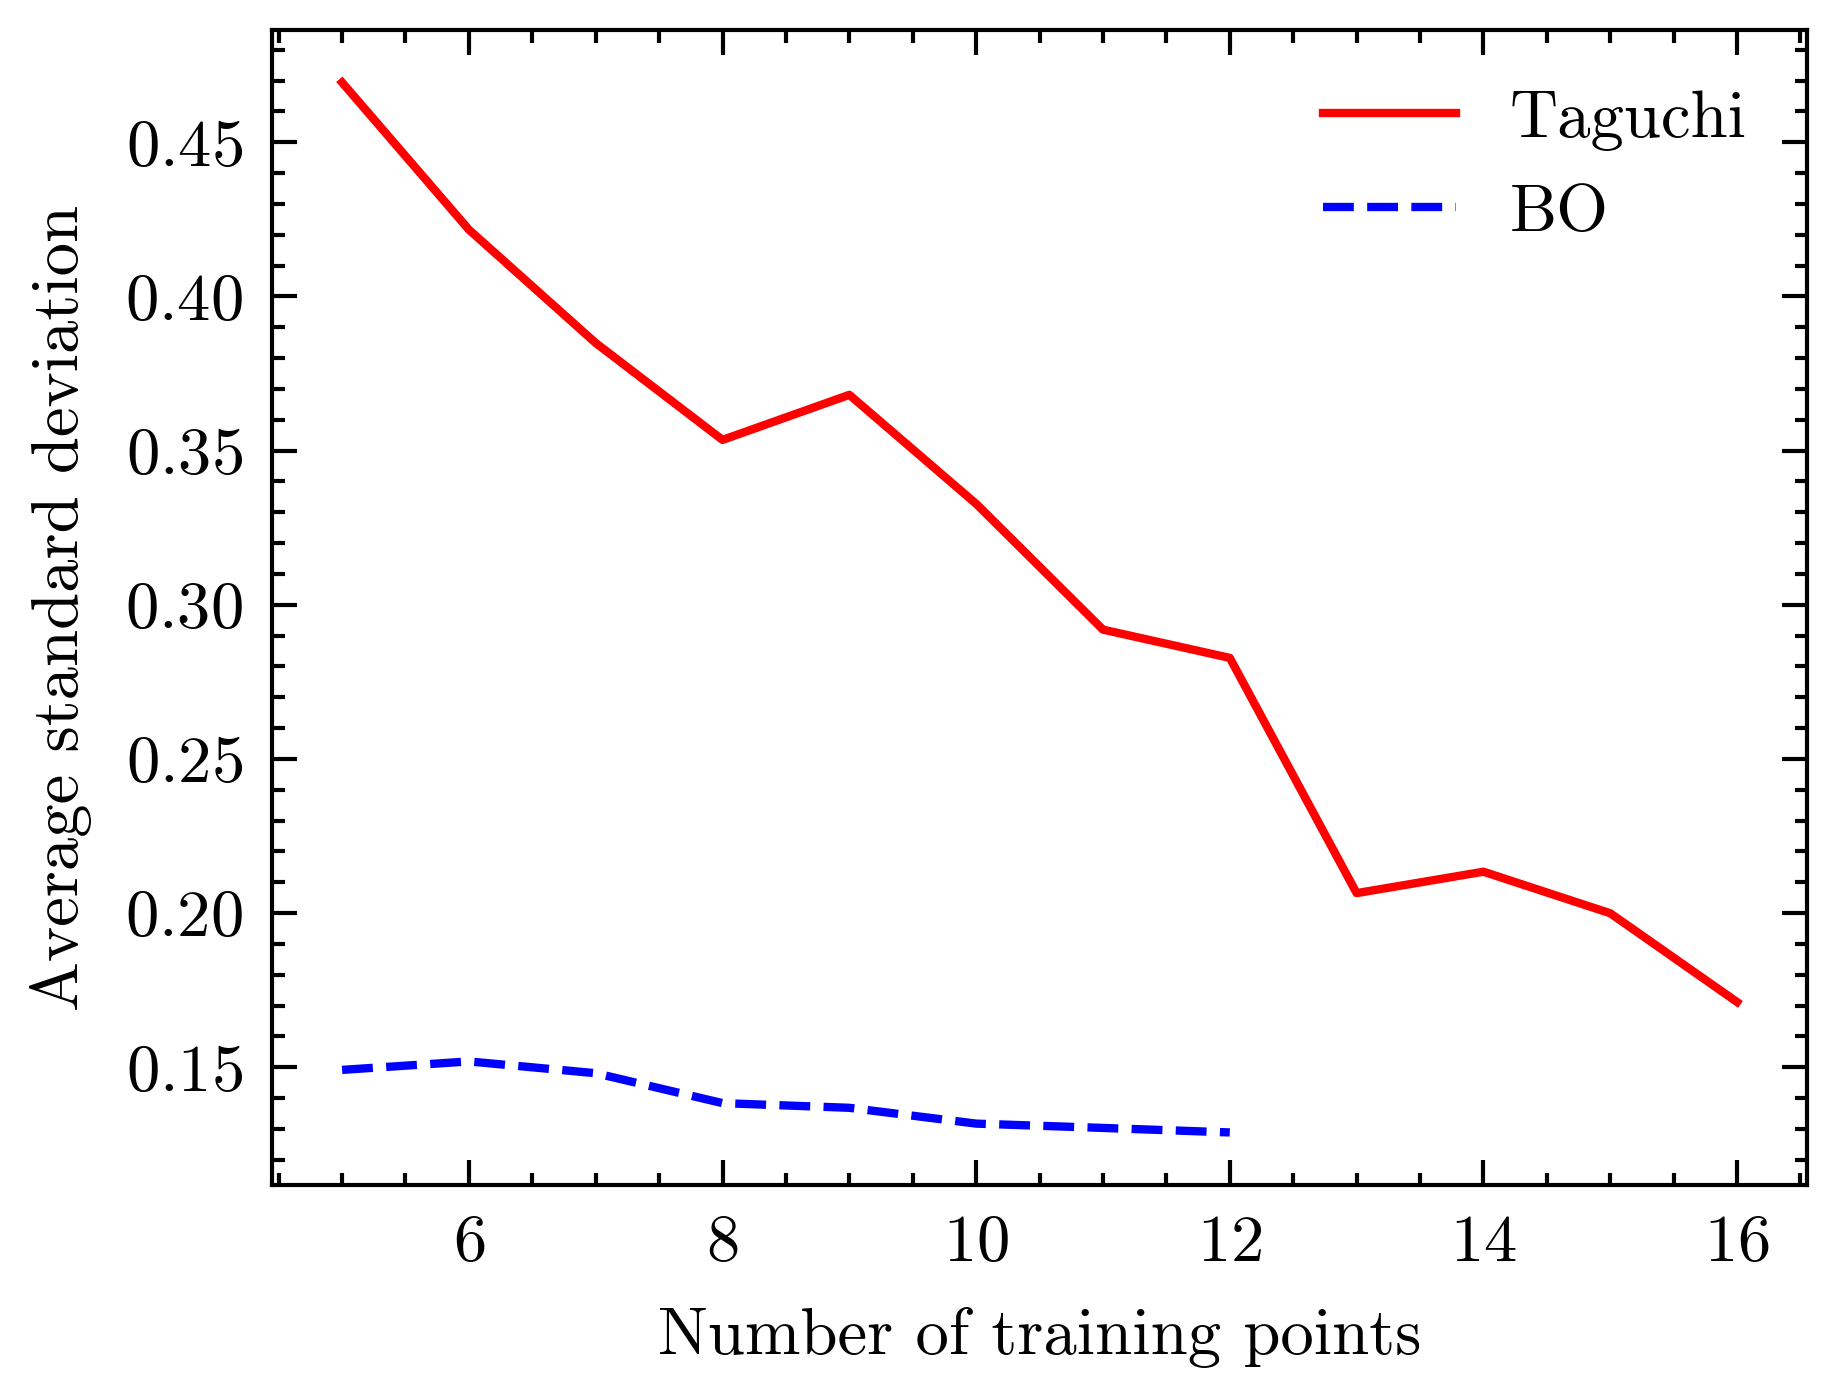

In [129]:
# plot accuracy/covariance as a function of # trials for each Taguchi & BO
with plt.style.context(['science','ieee','no-latex']):
    t_inds = range(num_init, num_init + len(avg_covariance))
    b_inds = range(num_init, num_init + len(prev_BO_df[np.isfinite(prev_BO_df['crack_pressure'])]) + 1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,np.sqrt(avg_covariance), c='r', label='Taguchi')
    ax.plot(b_inds,np.sqrt(avg_SEM), c='b', label='BO')
    ax.set_xlabel('Number of training points')
    ax.set_ylabel('Average standard deviation')
    # ax.set_yscale('log')
    plt.legend()
    plt.show()

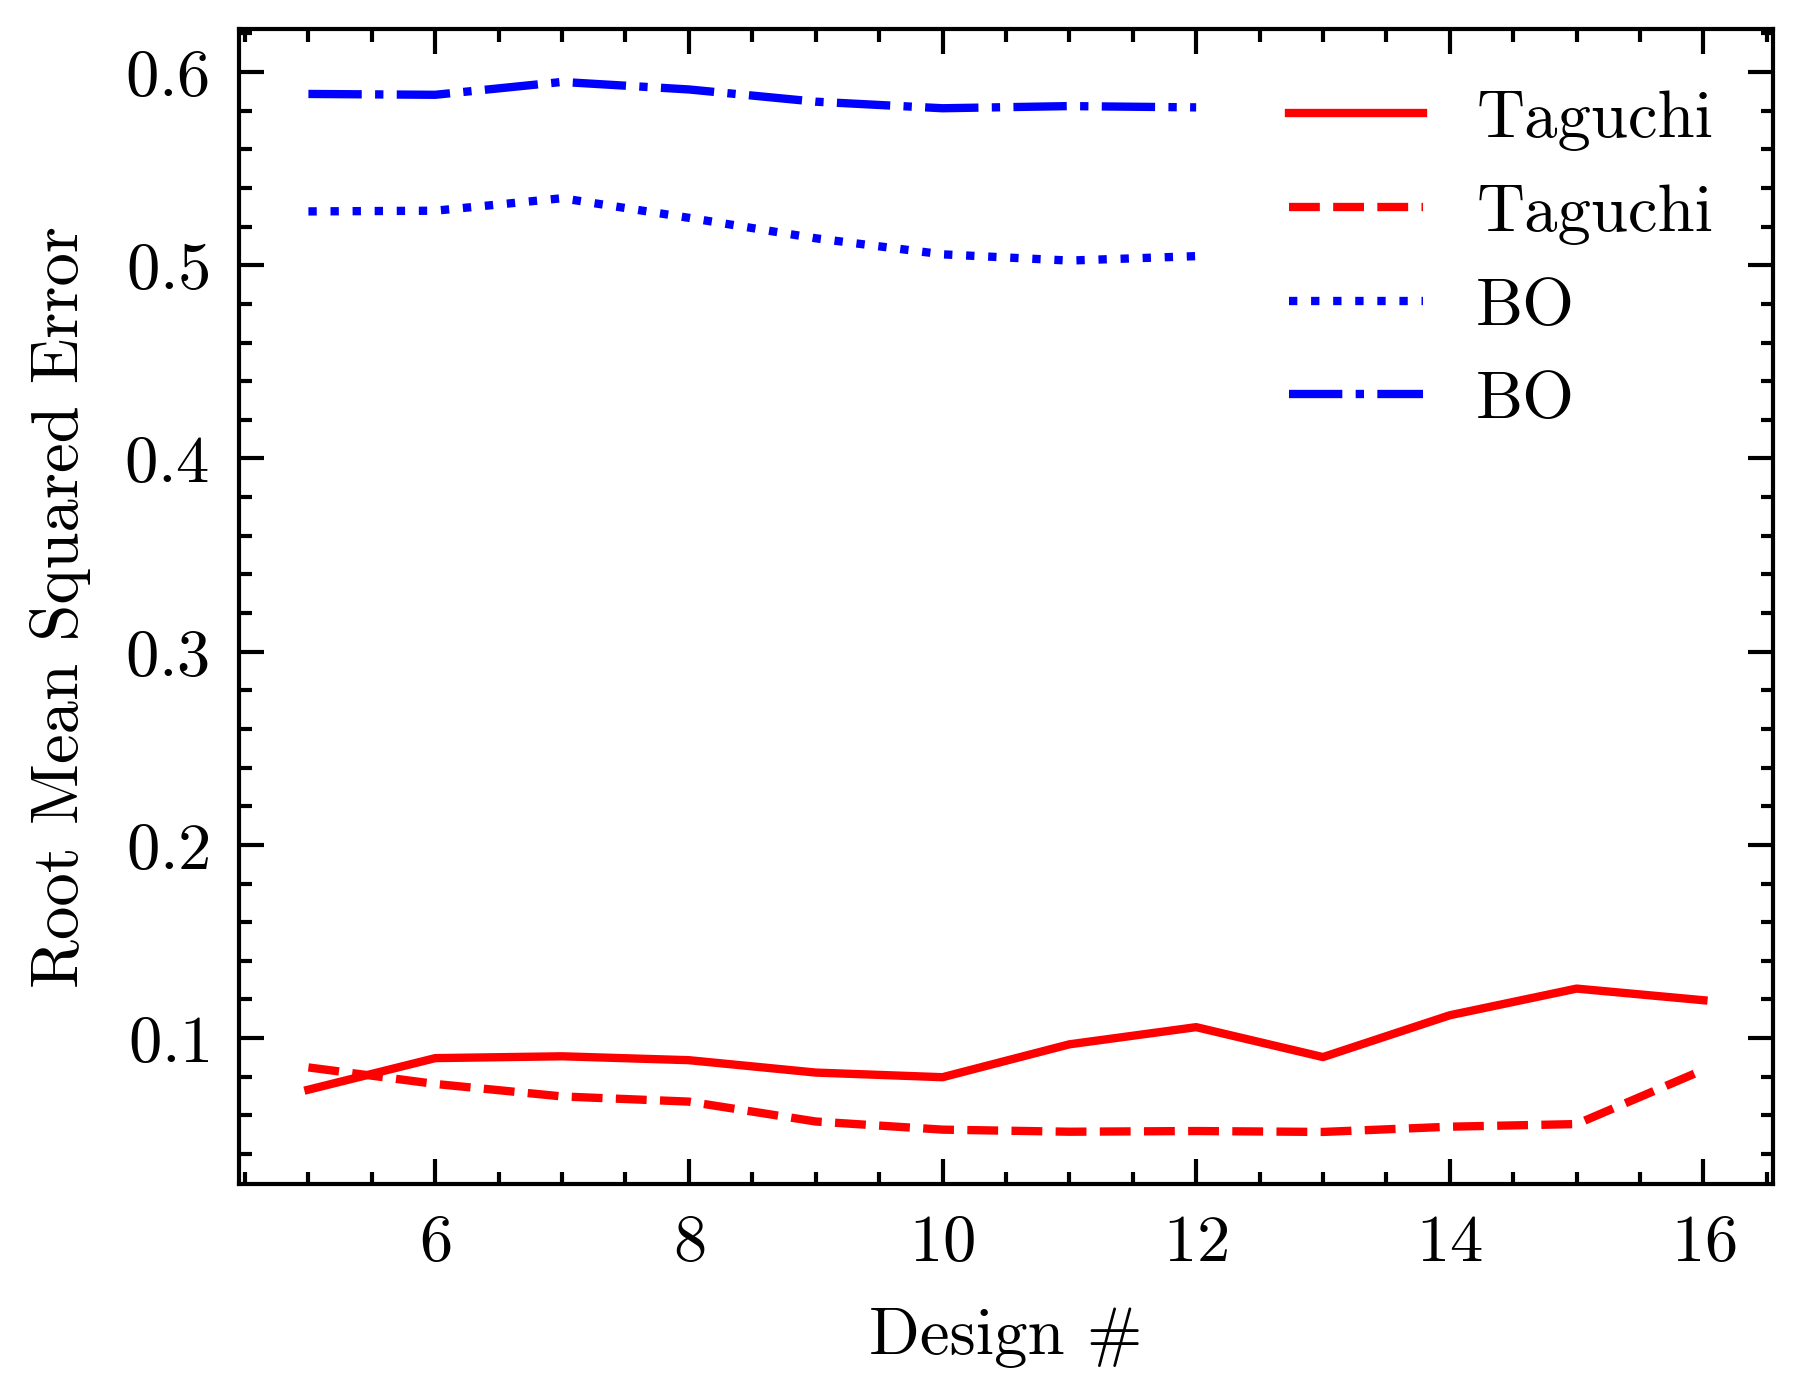

In [130]:
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,tag_accuracy, c='r', label='Taguchi')
    ax.plot(b_inds,BO_accuracy, c='b', label='BO')
    ax.set_xlabel('Design #')
    ax.set_ylabel('Root Mean Squared Error')
    plt.legend()
    plt.show()

In [131]:
pickle.dump(all_BO_acc,open('all_BO_acc_valve_0.0.pkl', 'wb'))
pickle.dump(all_tag_error,open('all_tag_error_valve_0.0.pkl', 'wb'))
pickle.dump(all_BO_SEM,open('all_BO_SEM_valve_0.0.pkl', 'wb'))
pickle.dump(all_tag_SEM,open('all_tag_SEM_valve_0.0.pkl', 'wb'))